107062566

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import scipy.misc
from libs import utils

In [3]:
VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)
    
    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [4]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image


VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None, STYLE_LAYERS=('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'), 
           CONTENT_LAYERS=('relu4_2', 'relu5_2')):    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights[CONTENT_LAYERS[0]] = content_weight_blend 
    content_layers_weights[CONTENT_LAYERS[1]] = 1.0 - content_weight_blend      

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
#         print_progress()
        pass
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
#           print_progress()
            pass

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")

def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

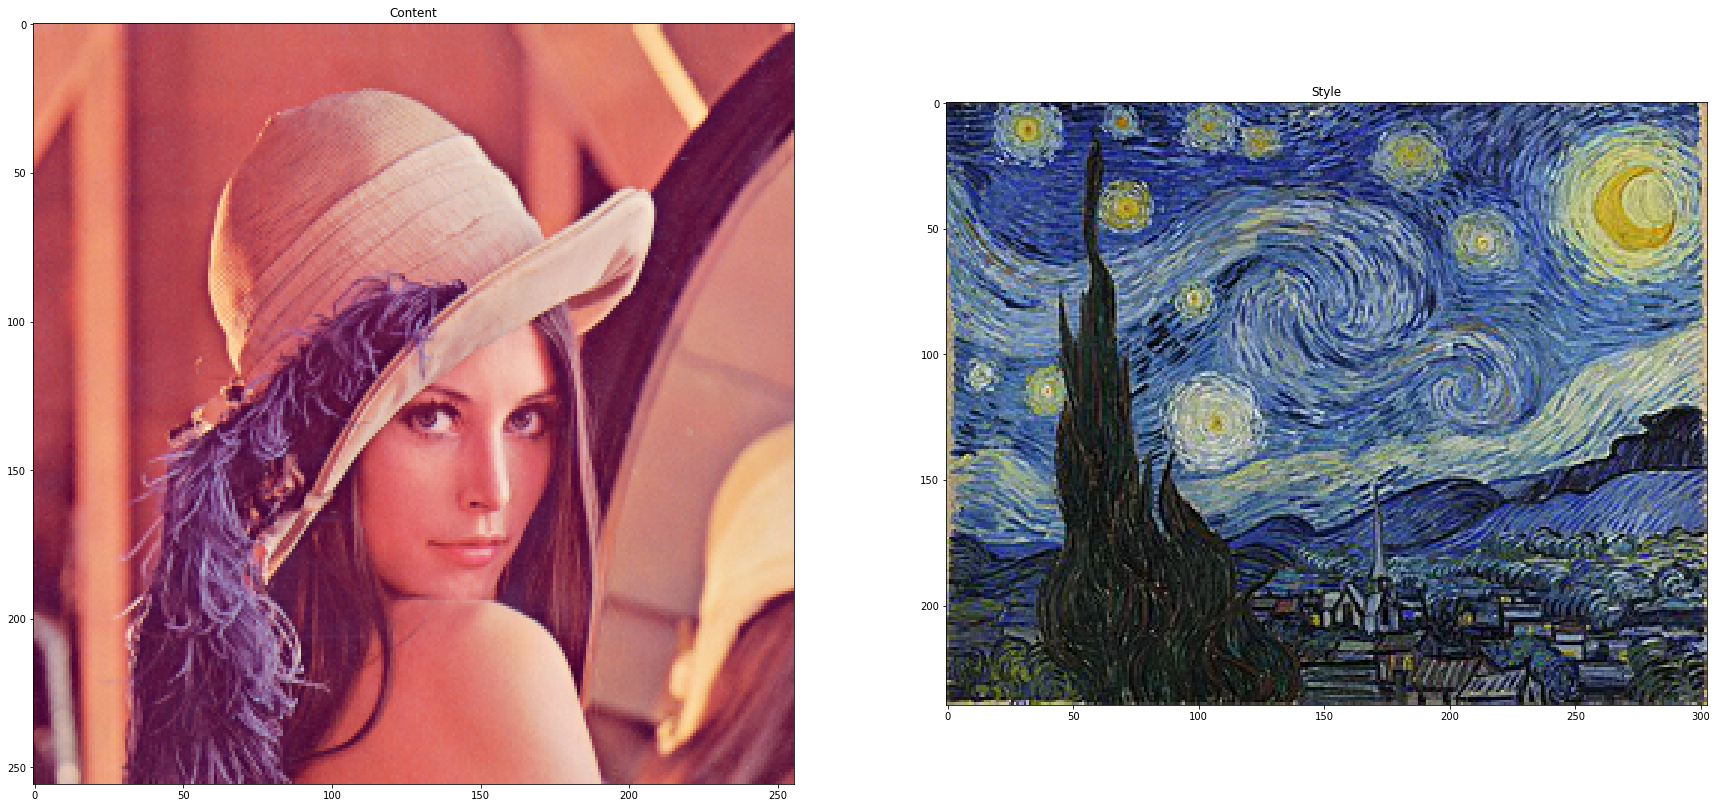

In [5]:
content_image = utils.loadImage('./data/', 'lenna.jpg')
style_image = utils.loadImage('./data/', 'starry_night.jpg')
utils.showImage(content_image, style_image)

finish stylizing.


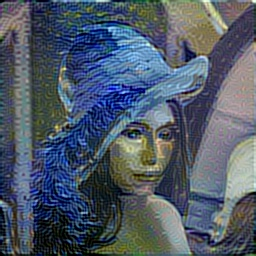

In [6]:
checkpoint_path=None
output_path = './data/' + 'out1.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

display.Image(output_path)

finish stylizing.


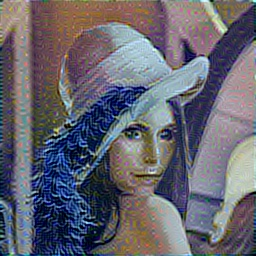

In [7]:
checkpoint_path=None
output_path = './data/' + 'out2.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e1, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

display.Image(output_path)

finish stylizing.


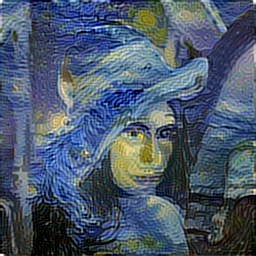

In [8]:
checkpoint_path=None
output_path = './data/' + 'out3.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e3, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

display.Image(output_path)

finish stylizing.


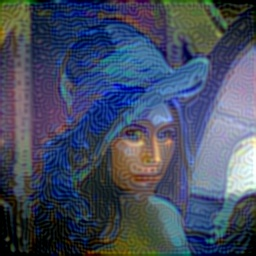

In [9]:
checkpoint_path=None
output_path = './data/' + 'out4.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=1500,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

display.Image(output_path)

finish stylizing.


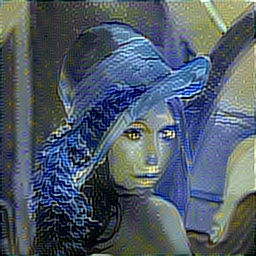

In [10]:
checkpoint_path=None
output_path = './data/' + 'out5.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path, STYLE_LAYERS=['pool1', 'pool2'])

display.Image(output_path)

finish stylizing.


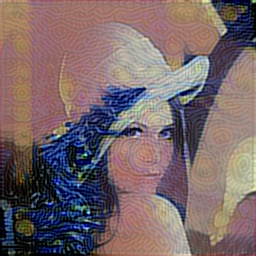

In [11]:
checkpoint_path=None
output_path = './data/' + 'out6.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path, CONTENT_LAYERS=['relu1_2', 'relu2_2'])

display.Image(output_path)

# Report

## Change Content Weight (`out1.jpg` vs `out2.jpg`)

權重越高，結果受原圖影響越大

## Change Style Weight (`out1.jpg` vs `out3.jpg`)

權重越高，結果受風格圖影響越大

## Change TV Weight (`out1.jpg` vs `out4.jpg`)

權重越高，結果感覺越平滑

## `STYLE_LAYERS=['pool1', 'pool2']` (`out1.jpg` vs `out5.jpg`)

感覺使用越低階的 style feature，線條與顏色的變化越強

## `CONTENT_LAYERS=['relu1_2', 'relu2_2']` (`out1.jpg` vs `out6.jpg`)

感覺使用越低階的 content feature，結果越跟原圖相近

## 心得

看起來效果不錯，但這似乎只能針對強烈藝術風格的圖片使用。